kNN 알고리즘은 주변의 가까운 사람들에게 물어봐서 대다수의 답변과 동일하게 답변하는 방법이다.  
만약 3명에게 물어봤을 때 2명이 거짓ㅇ로 대답한다면 예측은 틀리게 된다.  
서포트 백터 머신은 '지금 이곳이 한강의 북쪽인지 남쪽인지?'와 같이 질문해서 답변을 얻는 방법이다.
***
서포트 백터라는 개념은 한강의 위치를 찾는데 사용되는 개념으로 한강은 도시가 강북인지 강남인지 구분하는 결정경계선(decision boundery)이다.  
서포트 백터는 결정 경계선을 찾은데 사용되는 개념이고, 백터는 2차원 공간상에 나타나는 데이터 포인트를 의미한다.  
따라서 서포트 백터는 결정 경계선과 가장 가까이 맞닿은 데이터 포인트를 의미한다.
***
서포트 백터와 결정 경계선 사이의 거리를 마진이라 하고 서포트 백터 머신의 목표는 마진을 최대로 하는 결정 경계를 찾는 것이다.  
서포트 백터 머신에서는 약간의 오류를 허용하기 위해 비용(C)이라는 변수를 사용한다.  
비용이 낮을수록 마진을 최대한 높이고, 학습 에러율을 증가하는 방향으로 결정 경계선을 만들고, 비용이 높을 수록 마진은 낮아지고, 학습율은 감소하는 방향을 결정 경계로 만든다.  
비용이 너무 낮으면 과소 적합의 위험이 있고, 너무 높으면 과대 적합의 위험이 있으니 적절한 비용값을 찾는 과정이 상당히 중요하다.

In [1]:
%config Completer.use_jedi = False
import warnings
warnings.filterwarnings(action='ignore')
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

In [2]:
# 최적의 비용과 감마값을 알아내기 위해 GridSearchCV() 함수를 import 한다.
from sklearn.model_selection import GridSearchCV

# SVM 알고리즘을 사용하기 위해 SVC() 함수를 import한다.
from sklearn.svm import SVC

# 분류 결과 정확도, 정밀도, 재현율, f1 점수 리포트를 출력하기 위해 classification_report() 함수를 import한다. 
from sklearn.metrics import classification_report

In [3]:
df = pd.read_csv('./data/basketball_stat.csv')
df.drop(['2P', 'AST', 'STL'], axis=1, inplace=True)
train, test = train_test_split(df, train_size=0.8)
df.head()

,Player,Pos,3P,TRB,BLK
0,Alex Abrines,SG,1.4,1.3,0.1
1,Steven Adams,C,0.0,7.7,1.0
2,Alexis Ajinca,C,0.0,4.5,0.6
3,Chris Andersen,C,0.0,2.6,0.6
4,Will Barton,SG,1.5,4.3,0.5


커널 트릭(kernel trick)  
저차원 백터 공간의 데이터를 고차원 벡터 공간의 욺겨줌으로써 결정 경계를 찾는 방법이다.  
저차원의 데이터를 고차원의 데이터로 옮겨주는 함수를 매핑 함수라 하고 매핑 함수를 가지고 많은 양의 데이터를 자차원에서 고차원으로 옮기기에는 계산량이 너무 많아져서 현실적으로 사용하기 어렵다.  
실제로 데이터를 고차원으로 보내지는 않지만 보낸 것과 동일한 효과를 줘서 빠를 속도로 결정 경계를 찾는 방법이 고안되었으며 이를 커널 트릭이라 한다.

최적의 SVM파라미터 찾기  
SVM에서 RBF(가우시안) 커널을 사용하므로 마진의 너비를 조정하는 파라미터(C)와 결정 경계선의 곡률을 조정하는 파라미터(gamma)를 알아야 한다.  
사이킷럼의 그리드 서치(grid search)를 개발자가 부여한 비용과 감마의 후보들을 조합해서 최적의 비용과 감마값을 알아낸다

In [4]:
# 사이킷런에서 제공하는 GridSearchCV() 함수를 사용해서 최적의 비용과 감마값을 알아내는 함수
def svm_param_selection(x, y, nfold):
    # 비용과 감마값의 후보를 정한다.
    svm_parameters = [{
        'kernel' : ['rbf'],
        'gamma' : [0.00001, 0.0001, 0.001, 0.01, 0.1, 1],
        'C' : [0.01, 0.1, 1, 10, 100, 1000]
    }]
    
    clf = GridSearchCV(SVC(), svm_parameters, cv=nfold) # Gridsearch 객체를 만든다.
    clf.fit(x, y.values.ravel()) # Gridsearch를 학습시킨다.
    print(clf.best_score_) # 최고 점수
    print(clf.best_params_, clf.best_params_['C'], clf.best_params_['gamma']) # 최고 점수를 낸 파라미터
    print(clf.best_estimator_) # 최고 점수를 낸 파라미터를 가진 SVC객체 모델
    return clf 

In [5]:
x_train = train[['3P', 'BLK']] # 3점 슛과 블로킹 홧수를 학습 데이터로 지정한다.
y_train = train['Pos'] # 포지션을 실제값으로 지정한다.
clf = svm_param_selection(x_train, y_train, 10)

0.95
{'C': 0.1, 'gamma': 1, 'kernel': 'rbf'} 0.1 1
SVC(C=0.1, gamma=1)


결정 경계 시각화

In [6]:
# 최고 점수를 낸 파라미터를 이용해서 시각화할 비용 후보들을 저장한다.
C_canditates = []
C_canditates.append(clf.best_params_['C'] * 0.01)
C_canditates.append(clf.best_params_['C']) # 최적의 'C'값
C_canditates.append(clf.best_params_['C'] * 100)
print(C_canditates)

# 최고 점수를 낸 파라미터를 이용해서 시각화할 감마 후보들을 저장한다.
gamma_canditates = []
gamma_canditates.append(clf.best_params_['gamma'] * 0.01)
gamma_canditates.append(clf.best_params_['gamma']) # 최적의 'gamma'값
gamma_canditates.append(clf.best_params_['gamma'] * 100)
print(gamma_canditates)

[0.001, 0.1, 10.0]
[0.01, 1, 100]


시각화를 위해 포지션(센터: C = 0, 슈팅가드 : SG = 1)을 숫자로 표현한다.

In [7]:
position = []
for i in y_train:
    if i == 'C' :
        position.append(0)
    else :
        position.append(1)
print(position)

[0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0]


최적의 파라미터 후보들을 조합해서 학습한 모델을 저장한다.

In [8]:
classifiers = []
for C in C_canditates:
    for gamma in gamma_canditates:
        clf = SVC(C=C, gamma=gamma) # 최적의 파라미터 후보들을 조합해서 서포트 백터 머신 모델을 만든다.
        clf.fit(x_train, y_train) # 최적의 파라미터 후보들을 조합해서 서포트 백터 머신 모델을 학습시킨다.
        classifiers.append([C, gamma, clf])
classifiers

[[0.001, 0.01, SVC(C=0.001, gamma=0.01)],
 [0.001, 1, SVC(C=0.001, gamma=1)],
 [0.001, 100, SVC(C=0.001, gamma=100)],
 [0.1, 0.01, SVC(C=0.1, gamma=0.01)],
 [0.1, 1, SVC(C=0.1, gamma=1)],
 [0.1, 100, SVC(C=0.1, gamma=100)],
 [10.0, 0.01, SVC(C=10.0, gamma=0.01)],
 [10.0, 1, SVC(C=10.0, gamma=1)],
 [10.0, 100, SVC(C=10.0, gamma=100)]]

각 모델을 시각화한다.

0 (0.001, 0.01, SVC(C=0.001, gamma=0.01))
1 (0.001, 1, SVC(C=0.001, gamma=1))
2 (0.001, 100, SVC(C=0.001, gamma=100))
3 (0.1, 0.01, SVC(C=0.1, gamma=0.01))
4 (0.1, 1, SVC(C=0.1, gamma=1))
5 (0.1, 100, SVC(C=0.1, gamma=100))
6 (10.0, 0.01, SVC(C=10.0, gamma=0.01))
7 (10.0, 1, SVC(C=10.0, gamma=1))
8 (10.0, 100, SVC(C=10.0, gamma=100))


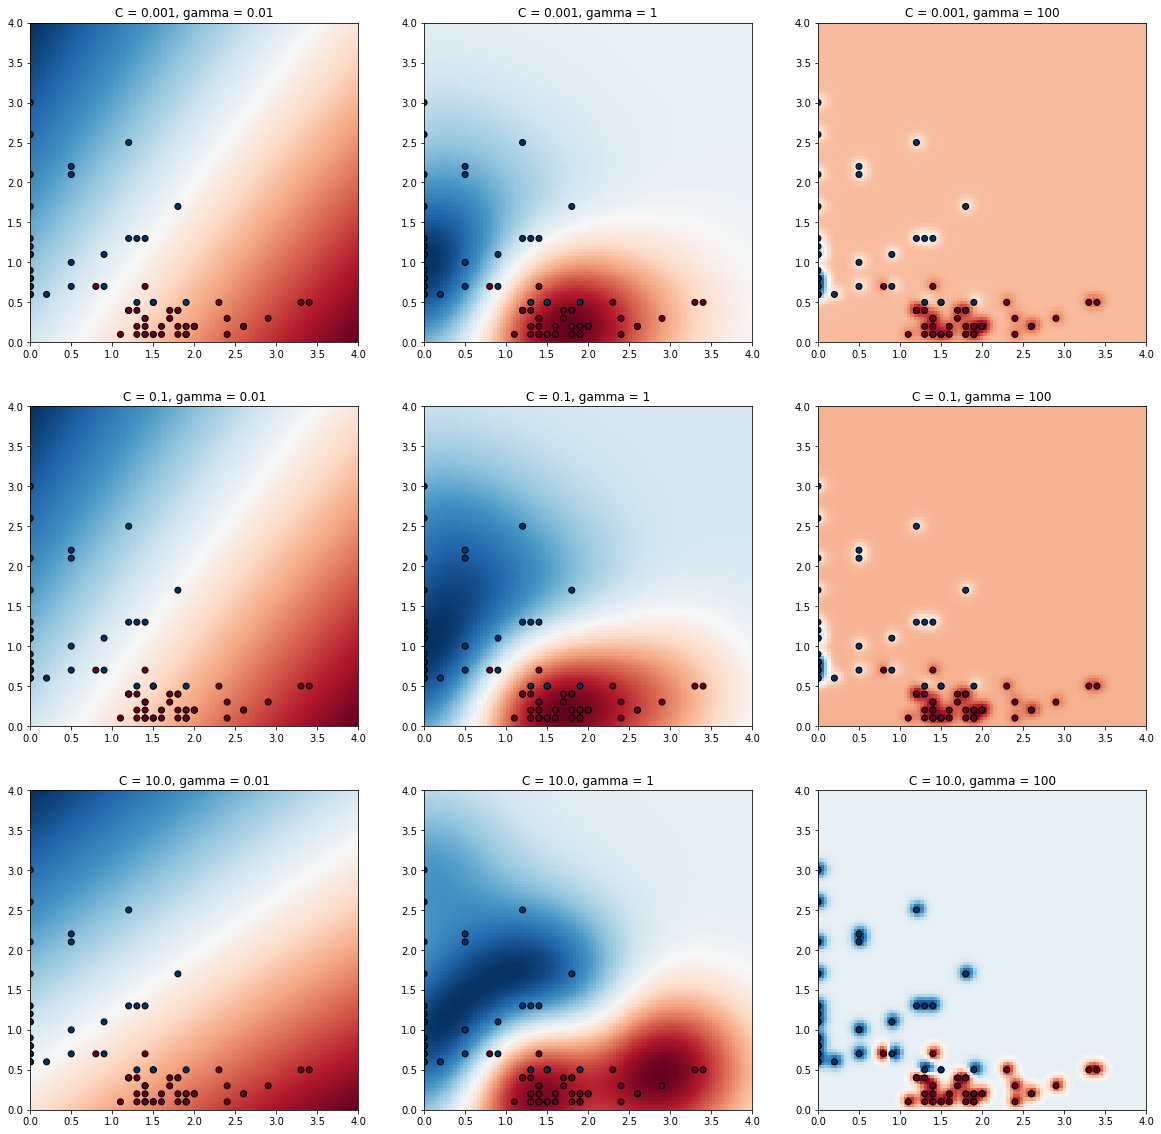

In [9]:
plt.figure(figsize=[20, 20])
# np.linspace(0, 4, 100): 0 ~ 4를 100 단계로 나눈 numpy 배열
# print(np.linspace(0, 4, 100))
xx, yy = np.meshgrid(np.linspace(0, 4, 100), np.linspace(0, 4, 100))

# enumerate(): 인수로 지정된 리스트를 인덱스와 값 형태의 튜플로 리턴한다.
for i, (C, gamma, clf) in enumerate(classifiers):
    print(i, (C, gamma, clf))
    
    # 넘파이 배열을 옆으로, 위아래로 붙이기: np.r_(), np.c_()
    # np.r_[a, b] => a, b 두 넘파이 배열을 왼쪽에서 오른쪽으로 붙인다.
    # np.r_[[a], [b]] => a, b 두 넘파이 배열을 위에서 아래쪽으로 붙인다.
    # np.c_[a, b] => 두 개의 1차원 배열을 컬럼으로 세로로 붙여서 2차원 배열을 만든다.
    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    # subplot 그래프: 두 개 이상의 그래프의 상관 관계를 효과적으로 표시할 수 있다.
    # subplot을 사용하는 방법은 subplot() 함수를 사용해서 그래프의 위치를 정해주고 그래프는 plot() 함수로 그리면 된다.
    plt.subplot(len(C_canditates), len(gamma_canditates), i + 1)
    plt.title('C = {}, gamma = {}'.format(C, gamma))
    
    # pcolormesh(): cmap으로 지정한 색상을 이용해서 xx, yy로 지정된 단계로 Z에 저장된 결정 경계면을 표시한다.
    plt.pcolormesh(xx, yy, -Z, cmap=plt.cm.RdBu)
    # x_train['3P']를 x축으로 x_train['BLK']를 y축으로하고 cmap 속성에서 지정한 색상(edgecolors는 테두리 색상)으로 c로
    # 구분해서 산점도 그래프를 그린다.
    plt.scatter(x=x_train['3P'], y=x_train['BLK'], c=position, edgecolors='k', cmap=plt.cm.RdBu_r)

plt. show()

위의 9개의 차트 중에서 정 가운데 차트가 GridSearchCV 함수를 통해 얻은 C와 gamma를 사용해 학습한 SVM 모델이며 균등하게 두 그룹이 분류된 것을 확인할 수 있다.  
결과 차트에서 좌에서 우로 보면 감마의 크기에 따른 결정 경게의 곡률 변화를 확인할 수 있고 위에서 아래로 보면 C의 크기에 따른 결정 경계의 위치 변화를 확인할 수 있다.  

모델 테스트

In [10]:
x_test = test[['3P', 'BLK']]
y_test = test['Pos']
# 최적의 파라미터로 학습된 모델로 테스트를 진행한다.
predict = clf.predict(x_test)
print('정확도: {}'.format(accuracy_score(y_test.values.ravel(), predict)))

NameError: name 'accuracy_score' is not defined

In [ ]:
print(classification_report(y_test.values.ravel(), predict))